# Workflow

## Goal
Determine which was the best classification method for determining whether a university was in the Northeast or the West

## Steps
1. General exploratory data analysis
2. Data cleaning (handling missing values)
3. Feature selection
4. Data cleaning (get dummies)
5. Run and optimize models
6. Evaluate models
7. Feature selection again
8. Repeat steps 5 and 6
9. Select final model

## Models Used
* **Dummy Classifier**
    + Using scikit-learn's dummy classifier with a stratified strategy
* **K-Nearest Neighbors**
    + Scaled variables
    + k = 1
* **Optimized K-Nearest Neighbors**
    + Evaluate using F1 score for k 1-25
    + k = 3
* **Decision Tree**
    + max_depth = 2
* **Optimized Decision Tree (max_depth)**
    + Evalute using F1 score for max_depth 1-10
    + max_depth = 8
* **Optimized Decision Tree (criterion, max_depth, min_samples_split)**
    + Evaluate using GridSearchCV
    + criterion = entropy
    + max_depth = 10
    + min_samples_split = 2
* **Random Forest**
    + n_estimators = 100
    + max_depth = 2
* **Optimized Random Forest (n_estimators, criterion, max_depth, min_samples_split)**
    + Evaluate using GridSearchCV
    + criterion = entropy
    + max_depth = 10
    + min_sample_split = 5
    + n_estimators = 125
* **AdaBoost**
    + n_estimators = 100
* **Optimized AdaBoost (n_estimators)**
    + Evaluate using cross validation score
    + n_estimators = 175
* **XGBoost**
* **Optimized XGBoost**
    + Evaluate using GridSearchCV
    + learning_rate = 0.1
    + max_depth = 6
    + min_child_weight = 1
    + n_estimators = 100
    + subsample = 0.5

## Final Model

Based on accuracy, precision, recall, F1-score, and interpretability, the final model I selected was the optimized random forest

# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools

# Import Classifiers & Packages for Modeling

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image  
from pydotplus import graph_from_dot_data

# Load Data

In [89]:
ipeds_data = pd.read_csv('ipeds_new_data.csv')
ipeds_data.drop('Unnamed: 0', axis = 1, inplace = True)
ipeds_data.head()

,unitid,inst_name,state_abbr,region,urban_centric_locale,title_iv_indicator,inst_control,institution_level,inst_category,inst_size,...,cb_region,headcount_asn_Total_prop,headcount_blk_Total_prop,headcount_hsp_Total_prop,headcount_hwnpi_Total_prop,headcount_mlt_Total_prop,headcount_nonres_Total_prop,headcount_ntv_Total_prop,headcount_unknown_Total_prop,headcount_wht_Total_prop
0,102553.0,University of Alaska Anchorage,AK,8.0,11.0,1.0,1.0,4.0,2.0,4.0,...,West,0.060485,0.030683,0.070895,0.006632,0.086845,0.015237,0.064473,0.072448,0.592302
1,102614.0,University of Alaska Fairbanks,AK,8.0,23.0,1.0,1.0,4.0,2.0,3.0,...,West,0.018203,0.022080,0.054947,0.008680,0.052419,0.011377,0.200067,0.181864,0.450362
2,102632.0,University of Alaska Southeast,AK,8.0,33.0,1.0,1.0,4.0,2.0,2.0,...,West,0.035880,0.011100,0.055756,0.007486,0.070986,0.009293,0.119773,0.156686,0.533041
3,102845.0,Charter College,WA,8.0,12.0,1.0,3.0,4.0,3.0,2.0,...,West,0.002653,0.062776,0.269231,0.055040,0.049735,0.000000,0.101459,0.055261,0.403846
4,103945.0,CollegeAmerica-Flagstaff,AZ,6.0,13.0,1.0,2.0,4.0,3.0,1.0,...,West,0.000000,0.022059,0.058824,0.007353,0.132353,0.000000,0.558824,0.000000,0.220588


In [4]:
ipeds_data.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari

# Exploratory Data Analysis

In [90]:
ipeds_data['cb_region'].replace({'Northeast': 0, 'West': 1}, inplace = True)

In [91]:
ipeds_data.cb_region.value_counts()

0    566
1    563
Name: cb_region, dtype: int64

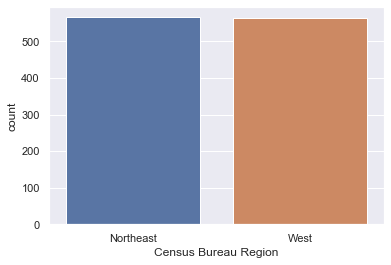

In [93]:
sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'cb_region', data = ipeds_data, ax = ax);
ax.set_xlabel('Census Bureau Region');
ax.set_xticklabels(['Northeast', 'West'])
plt.savefig('fig01_cb_region_hist.jpg')

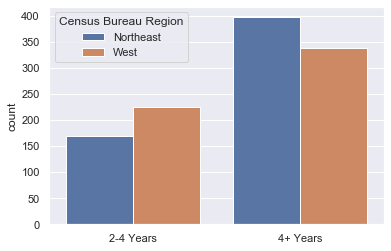

In [96]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'institution_level', hue = 'cb_region', data = ipeds_data, ax = ax);
ax.set_xlabel('');
ax.set_xticklabels(['2-4 Years', '4+ Years'])
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig02_inst_lvl.jpg')

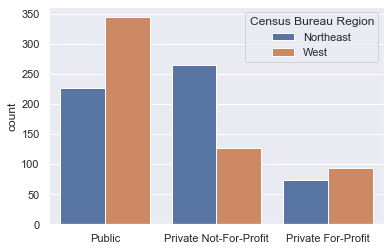

In [97]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_control', hue = 'cb_region', data = ipeds_data, ax = ax);
ax.set_xlabel('');
ax.set_xticklabels(['Public', 'Private Not-For-Profit', 'Private For-Profit']);
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig03_inst_control.jpg')

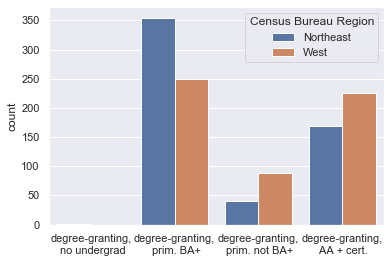

In [98]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_category', hue = 'cb_region', data = ipeds_data, ax = ax);
ax.set_xlabel('');
ax.set_xticklabels(['degree-granting,\n no undergrad', 
                    'degree-granting,\n prim. BA+', 'degree-granting,\n prim. not BA+', 
                    'degree-granting,\n AA + cert.']);
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig04_inst_category.jpg')

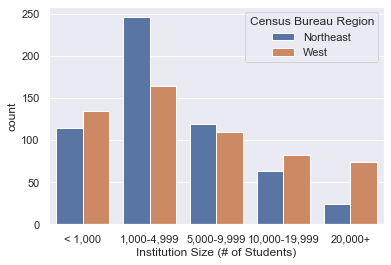

In [99]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_size', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['< 1,000', '1,000-4,999', '5,000-9,999', 
                    '10,000-19,999', '20,000+']);
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
ax.set_xlabel('Institution Size (# of Students)');
plt.savefig('fig05_inst_size.jpg')

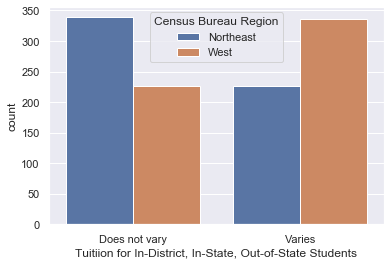

In [101]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'tuition_varies', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Does not vary', 'Varies']);
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
ax.set_xlabel('Tuitiion for In-District, In-State, Out-of-State Students');
plt.savefig('fig06_tuition_varies.jpg')

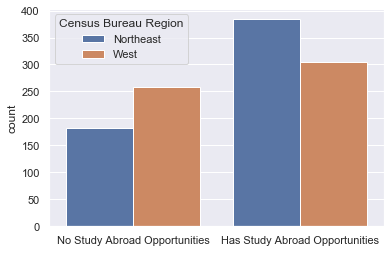

In [106]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'study_abroad', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['No Study Abroad Opportunities', 'Has Study Abroad Opportunities']);
ax.set_xlabel('')
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig07_study_abroad.jpg')

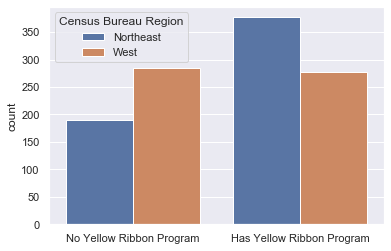

In [113]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'yellow_ribbon_program', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['No Yellow Ribbon Program', 'Has Yellow Ribbon Program']);
ax.set_xlabel('')
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig08_yellow_ribbon.jpg')

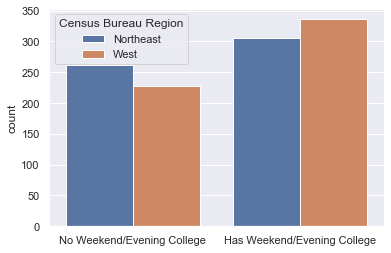

In [110]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'weekend_evening_college', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['No Weekend/Evening College', 'Has Weekend/Evening College']);
ax.set_xlabel('')
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig09_weekend_evening.jpg')

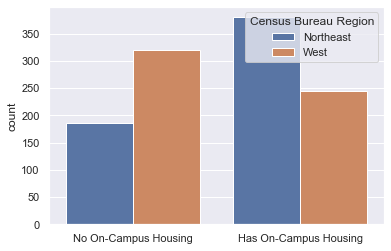

In [263]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'oncampus_housing', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['No On-Campus Housing', 'Has On-Campus Housing']);
ax.set_xlabel('')
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig10_oncampus_housing.jpg')

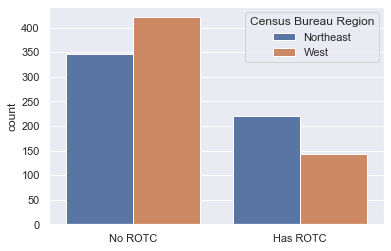

In [264]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'rotc', hue = 'cb_region', data = ipeds_data, ax = ax)
ax.set_xticklabels(['No ROTC', 'Has ROTC']);
ax.set_xlabel('')
ax.legend(labels = ['Northeast', 'West'], title='Census Bureau Region');
plt.savefig('fig11_rotc.jpg')

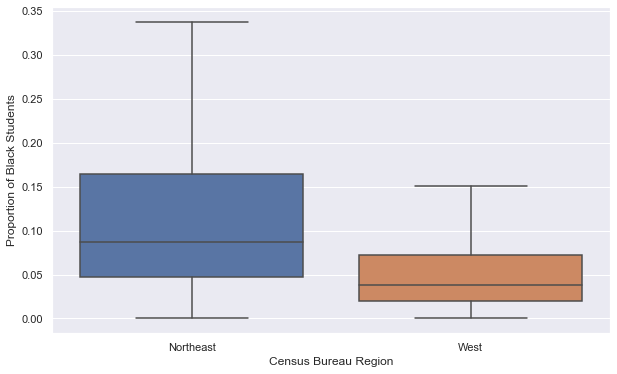

In [268]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_blk_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Black Students');
plt.savefig('fig12_prop_blk.jpg')

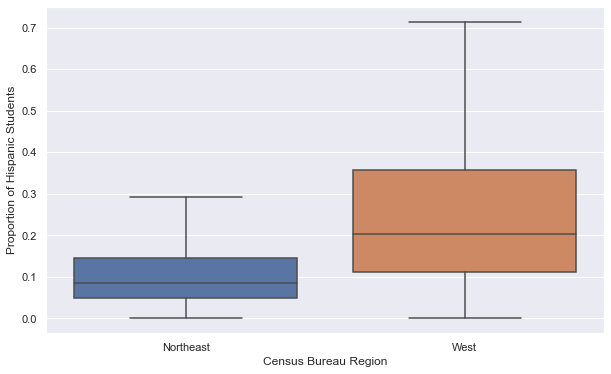

In [269]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hsp_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Hispanic Students');
plt.savefig('fig13_prop_hsp.jpg')

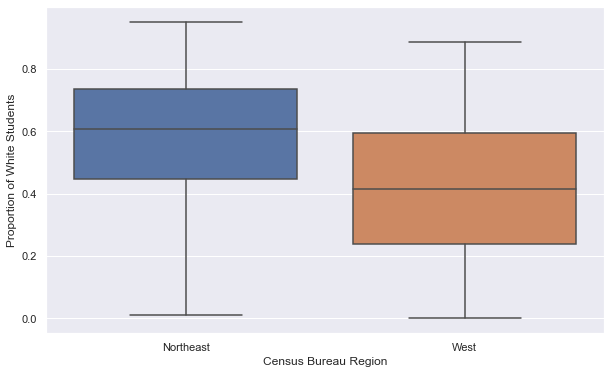

In [270]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_wht_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of White Students');
plt.savefig('fig14_prop_wht.jpg')

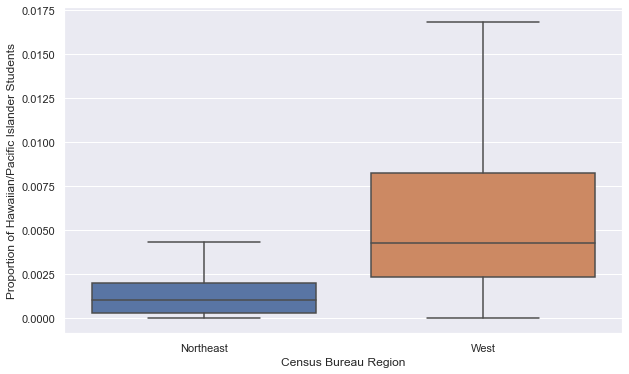

In [271]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hwnpi_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Hawaiian/Pacific Islander Students');
plt.savefig('fig15_prop_hwnpi.jpg')

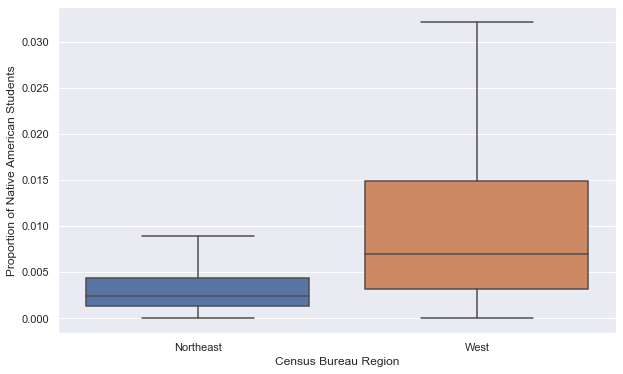

In [272]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_ntv_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Native American Students');
plt.savefig('fig16_prop_ntv.jpg')

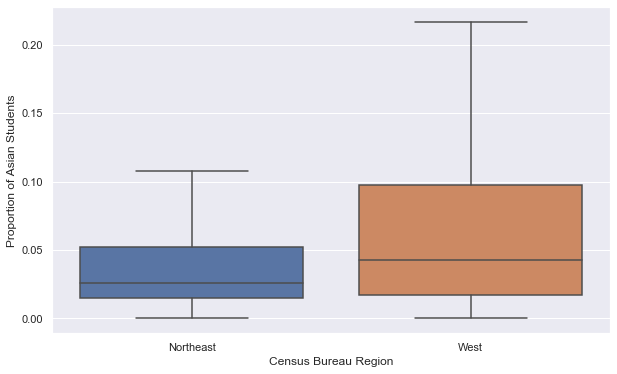

In [273]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_asn_Total_prop', data = ipeds_data, ax = ax, 
            showfliers = False)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Asian Students');
plt.savefig('fig17_prop_asn.jpg')

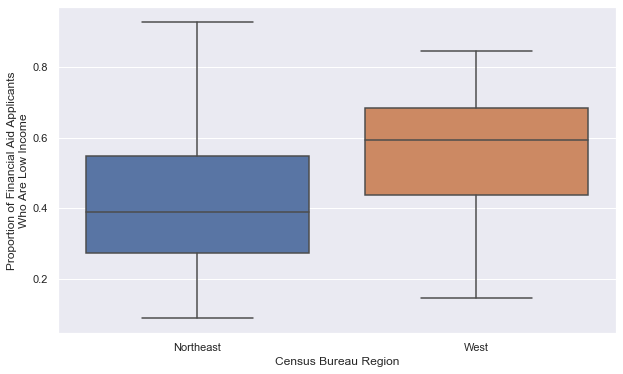

In [274]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'lowincome_pct', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Financial Aid Applicants\nWho Are Low Income');
plt.savefig('fig18_prop_lowincome.jpg')

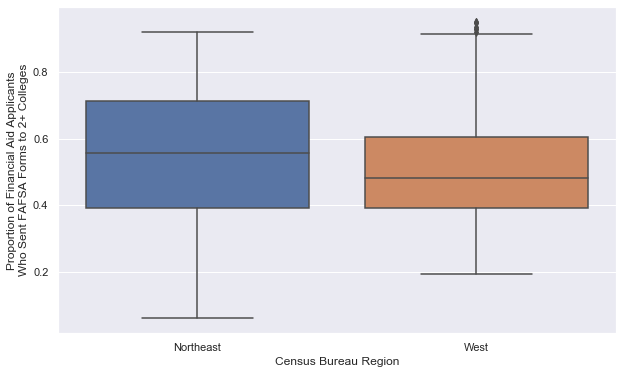

In [275]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'fafsa_sent_2ormore_pct', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Financial Aid Applicants\nWho Sent FAFSA Forms to 2+ Colleges');
plt.savefig('fig19_prop_fafsa_2more.jpg')

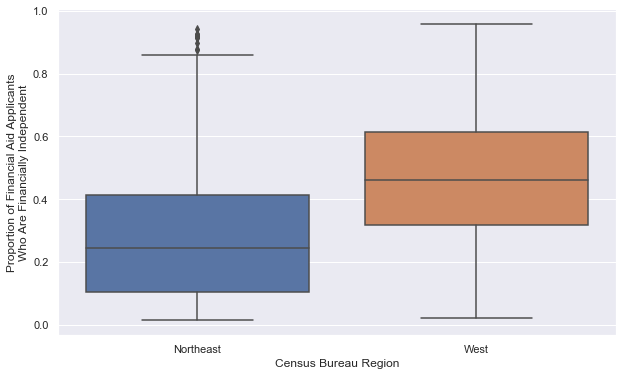

In [276]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'independent_pct', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Financial Aid Applicants\nWho Are Financially Independent');
plt.savefig('fig20_prop_independent.jpg')

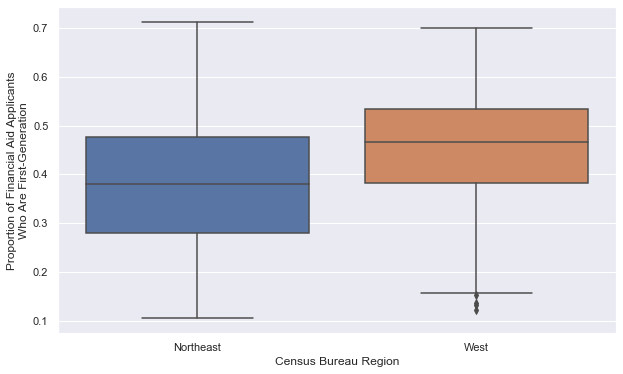

In [277]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'first_gen_student_pct', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Proportion of Financial Aid Applicants\nWho Are First-Generation');
plt.savefig('fig21_prop_first_gen.jpg')

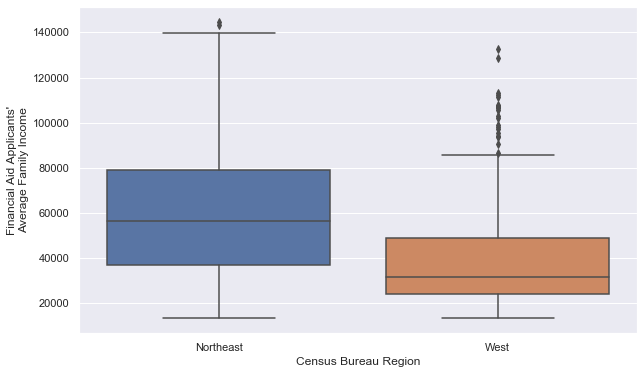

In [278]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'faminc_mean', data = ipeds_data, ax = ax)
ax.set_xticklabels(['Northeast', 'West']);
ax.set_xlabel('Census Bureau Region')
ax.set_ylabel('Financial Aid Applicants\'\nAverage Family Income');
plt.savefig('fig22_avg_fam_income.jpg')

# Make Dummy Variables

In [5]:
dummy_vars = ['institution_level', 'inst_control', 'inst_category', 'inst_size', 
              'tuition_varies', 'study_abroad', 'yellow_ribbon_program', 
              'weekend_evening_college', 'oncampus_housing', 'rotc']
cont_vars = ['headcount_blk_Total_prop', 'headcount_hsp_Total_prop', 
             'headcount_wht_Total_prop', 'headcount_hwnpi_Total_prop', 
             'headcount_ntv_Total_prop', 'headcount_asn_Total_prop', 
             'lowincome_pct', 'fafsa_sent_2ormore_pct', 
             'independent_pct', 'first_gen_student_pct', 'faminc_mean']

In [6]:
dummies = ipeds_data[dummy_vars].astype('str')
cont = ipeds_data[cont_vars]
X = pd.get_dummies(pd.concat([dummies, cont], axis = 1), drop_first = True)
y = ipeds_data['cb_region']

# Train, Test, Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

## Define Helper Function

In [165]:
regions = ['Northeast', 'West']
def plot_confusion_matrix(cm, classes, fig_name=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.21
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(b=None)
    if fig_name is not None:
        plt.savefig(fig_name)

In [36]:
# Returns dataframe of accuracy, precision, recall, and f1 score for training and testing data
def get_metrics(train_pred, test_pred):
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)

    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)

    train_f1 = f1_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    
    train_metrics = [round(train_accuracy * 100, 3), round(train_precision, 3), 
                     round(train_recall, 3), round(train_f1, 3)]
    test_metrics = [round(test_accuracy * 100, 3), round(test_precision, 3), 
                    round(test_recall, 3), round(test_f1, 3)]
    
    metrics = pd.DataFrame([train_metrics, test_metrics])
    metrics.index = ['Training Data', 'Testing Data']
    metrics.columns = ['Accuracy (%)', 'Precision', 'Recall', 'F1 Score']
    
    return metrics

In [288]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20, 13))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

# UNSCALED MODELS

# Baseline Model: Dummy Classifier (F1 = 0.45)

In [11]:
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, y_train)

# Predictions for train and test data
dummy_y_train_pred = dummy_clf.predict(X_train)
dummy_y_test_pred = dummy_clf.predict(X_test)

# Print classification reports
print(classification_report(y_train, dummy_y_train_pred))
print(classification_report(y_test, dummy_y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       392
           1       0.53      0.52      0.52       398

    accuracy                           0.52       790
   macro avg       0.52      0.52      0.52       790
weighted avg       0.52      0.52      0.52       790

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       174
           1       0.44      0.44      0.44       165

    accuracy                           0.45       339
   macro avg       0.45      0.45      0.45       339
weighted avg       0.45      0.45      0.45       339



In [37]:
# Print evaluation metrics
dummy_metrics = get_metrics(dummy_y_train_pred, dummy_y_test_pred)
dummy_metrics

,Accuracy (%),Precision,Recall,F1 Score
Training Data,52.152,0.525,0.523,0.522
Testing Data,45.428,0.440,0.442,0.454


Confusion Matrix, without normalization
[[81 93]
 [92 73]]


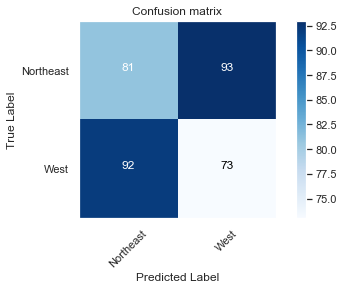

In [259]:
cm_dummy = confusion_matrix(y_test, dummy_y_test_pred)
plot_confusion_matrix(cm_dummy, regions, fig_name = 'fig23_cm_dummy.jpg',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

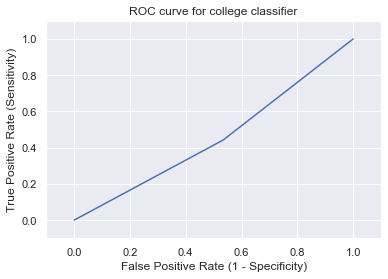

In [191]:
# First calculate the probability scores of each of the datapoints:
y_score = dummy_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Random Forest (n_est = 100, max_depth = 2) (F1 = 0.82)

In [195]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [196]:
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

Confusion Matrix, without normalization
[[132  42]
 [ 19 146]]


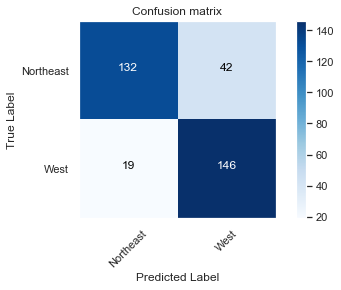

In [260]:
cm_forest = confusion_matrix(y_test, forest_test_pred)
plot_confusion_matrix(cm_forest, regions, fig_name = 'fig24_cm_forest.jpg',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [198]:
print(classification_report(y_test, forest_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       174
           1       0.78      0.88      0.83       165

    accuracy                           0.82       339
   macro avg       0.83      0.82      0.82       339
weighted avg       0.83      0.82      0.82       339



In [199]:
forest_metrics = get_metrics(forest_train_pred, forest_test_pred)
forest_metrics

,Accuracy (%),Precision,Recall,F1 Score
Training Data,86.456,0.826,0.927,0.864
Testing Data,82.006,0.777,0.885,0.820


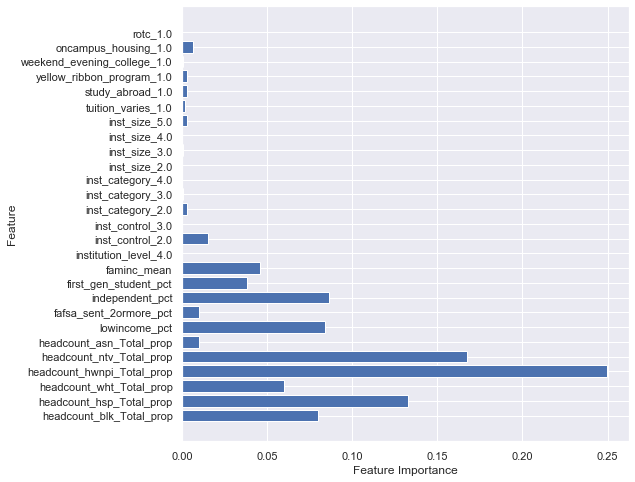

In [200]:
plot_feature_importances(forest.fit(X_train, y_train))

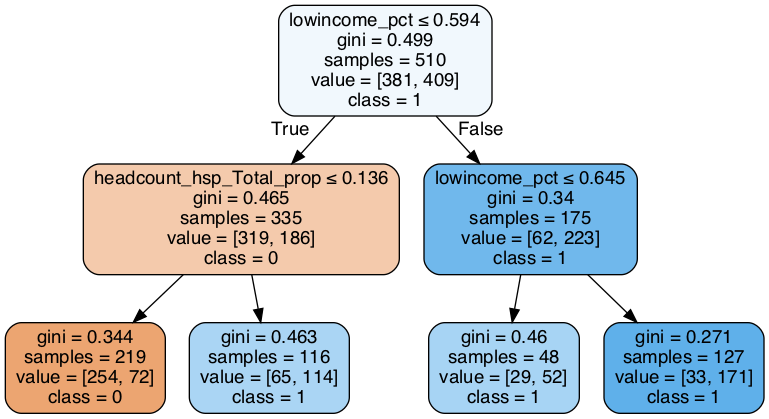

In [201]:
# Create DOT data
dot_data = export_graphviz(forest.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

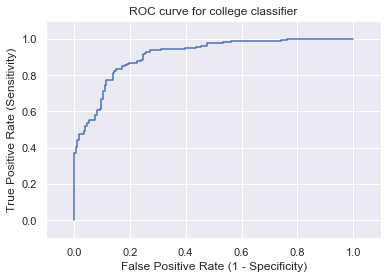

In [202]:
# First calculate the probability scores of each of the datapoints:
y_score = forest.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Optimize Random Forest Using GridSearchCV

In [203]:
forest_base = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 125, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20], 
    'max_features': [2, 'auto', 'log2']
}

gs_tree = GridSearchCV(forest_base, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 125}

## Random Forest (n_estimators = 125, max_depth = 10, min_samples_split = 5) (F1 = 0.93)

In [204]:
forest_opt = RandomForestClassifier(criterion = 'entropy', n_estimators = 125, 
                                    max_depth = 10, min_samples_split = 5, 
                                    random_state = 42)
forest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [205]:
forest_opt_train_pred = forest_opt.predict(X_train)
forest_opt_test_pred = forest_opt.predict(X_test)

Confusion Matrix, without normalization
[[163  11]
 [ 13 152]]


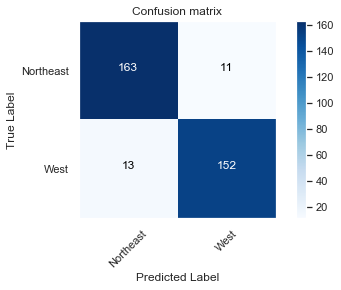

In [261]:
cm_forest_opt = confusion_matrix(y_test, forest_opt_test_pred)
plot_confusion_matrix(cm_forest_opt, regions, fig_name = 'fig25_cm_forest_opt.jpg',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [207]:
print(classification_report(y_test, forest_opt_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       174
           1       0.93      0.92      0.93       165

    accuracy                           0.93       339
   macro avg       0.93      0.93      0.93       339
weighted avg       0.93      0.93      0.93       339



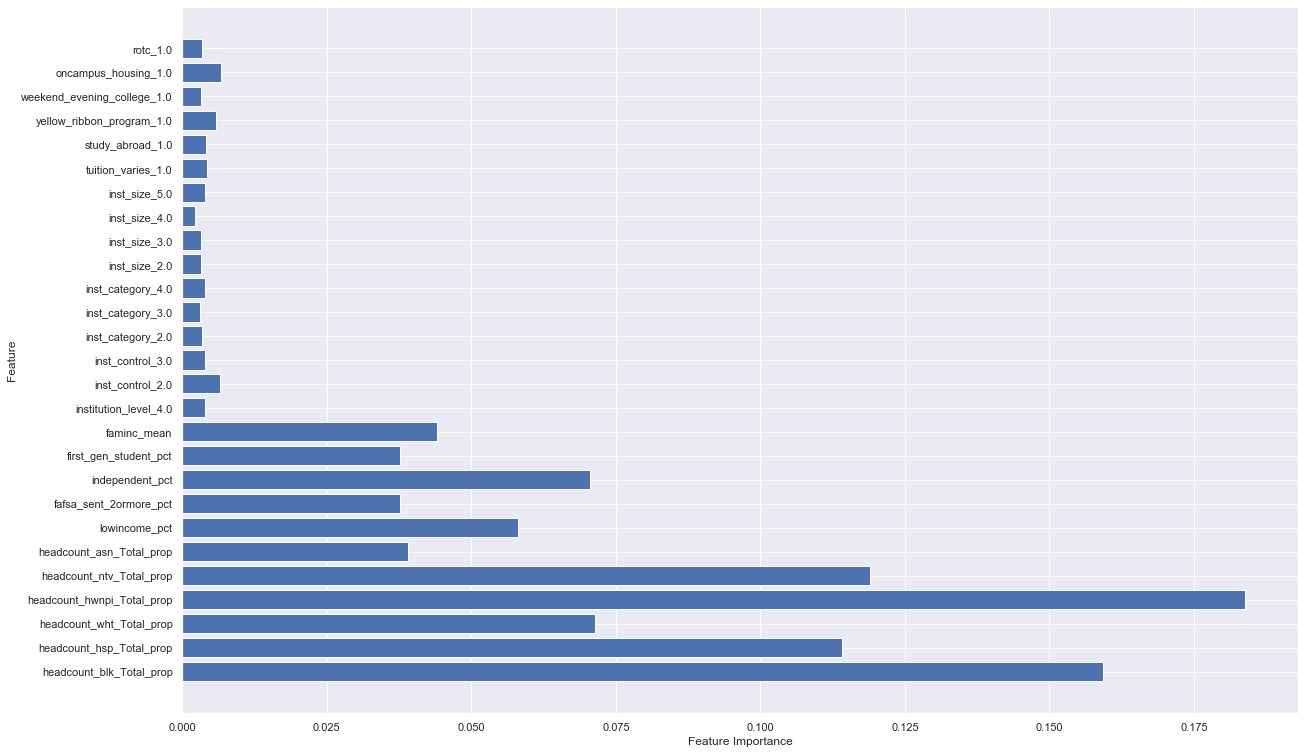

In [289]:
plot_feature_importances(forest_opt.fit(X_train, y_train))
plt.savefig('fig27_forest_opt_feat_impt.jpg')

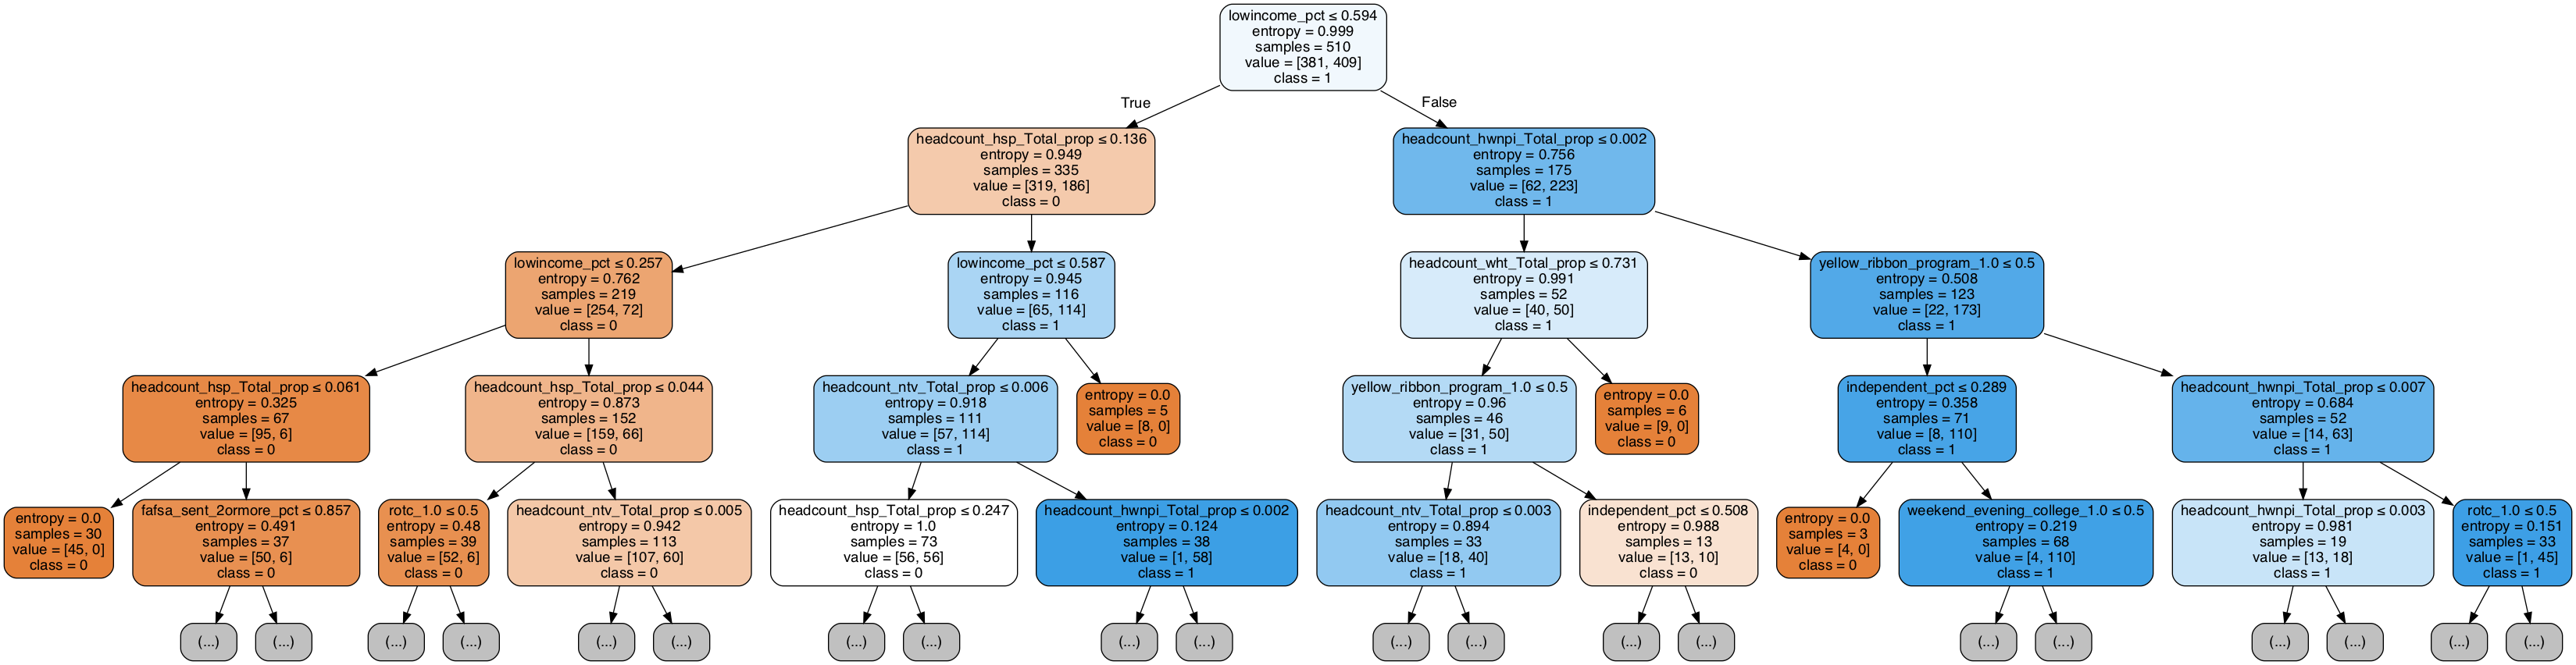

In [28]:
# Create DOT data
dot_data = export_graphviz(forest_opt.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True, 
                           max_depth = 4)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [209]:
forest_opt_metrics = get_metrics(forest_opt_train_pred, forest_opt_test_pred)
forest_opt_metrics

,Accuracy (%),Precision,Recall,F1 Score
Training Data,99.873,1.000,0.997,0.999
Testing Data,92.920,0.933,0.921,0.929


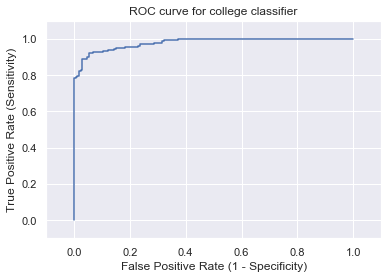

In [194]:
# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

# First calculate the probability scores of each of the datapoints:
y_score = forest_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Comparing ROC Curves

In [232]:
# First calculate the probability scores of each of the datapoints:
dummy_y_score = dummy_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
forest_y_score = forest.fit(X_train, y_train).predict_proba(X_test)[:, 1]
forest_opt_y_score = forest_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]

d_fpr, d_tpr, d_thresholds = roc_curve(y_test, dummy_y_score)
f_fpr, f_tpr, f_thresholds = roc_curve(y_test, forest_y_score)
f_opt_fpr, f_opt_tpr, f_opt_thresholds = roc_curve(y_test, forest_opt_y_score)

dummy_scores = pd.concat([pd.DataFrame(d_fpr), pd.DataFrame(d_tpr)], axis = 1)
dummy_scores['Model'] = 'Dummy'
dummy_scores.columns = ['False Positive Rate (1 - Specificity)', 
                        'True Positive Rate (Sensitivity)', 'Model']

forest_scores = pd.concat([pd.DataFrame(f_fpr), pd.DataFrame(f_tpr)], axis = 1)
forest_scores['Model'] = 'Random Forest'
forest_scores.columns = ['False Positive Rate (1 - Specificity)', 
                         'True Positive Rate (Sensitivity)', 'Model']

forest_opt_scores = pd.concat([pd.DataFrame(f_opt_fpr), pd.DataFrame(f_opt_tpr)], axis = 1)
forest_opt_scores['Model'] = 'Optimized Random Forest'
forest_opt_scores.columns = ['False Positive Rate (1 - Specificity)', 
                             'True Positive Rate (Sensitivity)', 'Model']


all_scores = pd.concat([dummy_scores, forest_scores, forest_opt_scores])

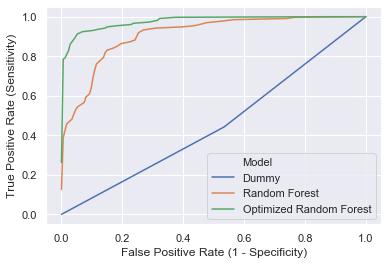

In [295]:
sns.lineplot(x="False Positive Rate (1 - Specificity)", y="True Positive Rate (Sensitivity)", 
             hue="Model", ci = None, data=all_scores);
plt.savefig('fig26_compare_final_models_roc.jpg')

In [280]:
dummy_metrics.index = ['Dummy Training', 'Dummy Testing']
forest_metrics.index = ['Random Forest Training', 'Random Forest Testing']
forest_opt_metrics.index = ['Opt. Random Forest Training', 'Opt. Random Forest Testing']

In [282]:
pd.concat([dummy_metrics, forest_metrics, forest_opt_metrics])

,Accuracy (%),Precision,Recall,F1 Score
Dummy Training,52.152,0.525,0.523,0.522
Dummy Testing,45.428,0.440,0.442,0.454
Random Forest Training,86.456,0.826,0.927,0.864
Random Forest Testing,82.006,0.777,0.885,0.820
Opt. Random Forest Training,99.873,1.000,0.997,0.999
Opt. Random Forest Testing,92.920,0.933,0.921,0.929
